In this notebook we are checking how much do the different models agree with each other, in terms of specific transfer event inferences

In [1]:
import pandas as pd
import numpy as np
import itertools
import os
from matplotlib import pyplot as plt
import matplotlib as mpl

compiled_res_dir = 'compiled_results/'
plots_dir = '../plots/'

In [2]:
plt_style_file = 'lib/plot.mplstyle'
plt.style.use(plt_style_file)
mpl.rc_file(plt_style_file)
# Scale the relevant rcParams by 2x
scale_factor = 2
for key in mpl.rcParams:
    try:
        if not 'size' in key:
            continue
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(mpl.rcParams[key], bool):
            mpl.rcParams[key] *= scale_factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [v*scale_factor if isinstance(
                v, (int, float)) and not isinstance(v, bool) else v for v in mpl.rcParams[key]]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

import json

# read in the marker styles
with open("lib/plot_marker_styles.json", "r") as fh:
    marker_styles_dict = json.load(fh)["marker_styles_dict"]
    # this is a dictionary such that for each method it contains
    # a dict of marker styles for 'marker_pyplot', 'marker_plotly', 'marker_color', 'face_color', 'label'

In [3]:
# this script calculates the intersections for each pair of methods, for each combination of thresholds
# it also calculates the number of transfers for each method, for each threshold

# first we read in all the compiled nogwise branchwise transfer data
transfer_filepaths = [f for f in os.listdir(compiled_res_dir) if f.startswith(
    'compiled_transfers.nogwise.branchwise')]
# read them into dfs, stored in a dict with the method name as the key
# for a filename, split it by period character, and take everything after the third period. Then remove everything after the last period
transfer_dfs = {f[f.find('compiled_transfers.nogwise.branchwise.') + len('compiled_transfers.nogwise.branchwise.'):f.find('.tsv')]:
                pd.read_csv(os.path.join(compiled_res_dir, f),
                            sep='\t', header=0, 
                            ) for f in transfer_filepaths}

# for each of these dfs, create a column 'source-recipient' combining the source and recipient columns
for method, df in transfer_dfs.items():
    df['source_branch'] = df['source_branch'].astype(str)
    df['recipient_branch'] = df['recipient_branch'].astype(str)
    df['source-recipient'] = df['source_branch'] + '-' + df['recipient_branch']

# we want to calculate intersections for each pair of methods
# this results in a df with columns 'method1', 'method2', 'method1_threshold', 'method2_threshold', 'jaccard_index', ...
# if the total number of unique values in 'transfers' is just 1, (e.g. in case of angst),
# we just do the calculation for the threshold 1.0 for that method, but across thresholds for the other method
# unless both of them have only 1 unique value, in which case we just do the calculation once
intersections_dfs = []
method_pairs = list(itertools.combinations(transfer_dfs.keys(), 2))


The following takes a few minutes to run

In [4]:
for method1, method2 in method_pairs:
    # if either of the methods has only 1 unique value, it doesn't need to be thresholded
    # for each method, we create a thresholds list, which is just [1.0] if the method has only 1 unique value <=1, and [0.0, 0.1, 0.2, ..., 1.0] otherwise
    thresholds1 = [1.0] if sum(transfer_dfs[method1]['transfers'].unique() <= 1) == 1 else np.arange(0, 1.1, 0.1)
    thresholds2 = [1.0] if sum(transfer_dfs[method2]['transfers'].unique() <= 1) == 1 else np.arange(0, 1.1, 0.1)

    # for each combination of thresholds, calculate the intersections
    # if either of the methods has only 1 unique value, only the recipient branches are compared instead of the source-recipient branches
    for threshold1 in thresholds1:
        for threshold2 in thresholds2:
            if len(thresholds1) == 1 or len(thresholds2) == 1:
                branch_label = 'recipient_branch'
            else:
                branch_label = 'source-recipient'
            set1 = set(transfer_dfs[method1][transfer_dfs[method1]
                       ['transfers'] >= threshold1][branch_label])
            set2 = set(transfer_dfs[method2][transfer_dfs[method2]
                       ['transfers'] >= threshold2][branch_label])
            if len(set1) == 0:
                continue
            if len(set2) == 0:
                continue
            set_union = len(set1.union(set2))
            set_intersection = len(set1.intersection(set2))
            branch_type = 'source-recipient' if branch_label == 'source-recipient' else 'recipient'            

            jaccard_index = len(set1.intersection(set2)) / \
                len(set1.union(set2))
            overlap_coefficient = len(
                set1.intersection(set2)) / min(len(set1), len(set2))

            method1_transfers = len(set1); method2_transfers = len(set2)

            intersections_dfs.append(pd.DataFrame({'method1': method1, 'method2': method2,
                                             # the thresholds for each method should be written without too many decimal places
                                             'method1_threshold': round(threshold1, 1), 'method2_threshold': round(threshold2, 1),
                                             # number of transfers for method1 and method2, for the given thresholds
                                             'method1_transfers': method1_transfers, 'method2_transfers': method2_transfers,
                                                'branch_type': branch_type, 
                                                'set_union': set_union, 'set_intersection': set_intersection,
                                             'jaccard_index': jaccard_index, 'overlap_coefficient': overlap_coefficient,
                                             }, index=[0]))
# now we have a list of dfs, we can concatenate them into one df
intersections_df = pd.concat(intersections_dfs)
# show the df
display(intersections_df)
# write the df to a file
intersections_df.to_csv(os.path.join(compiled_res_dir, 'intersections.nogwise.branchwise.tsv'),
                  sep='\t', index=False)

,method1,method2,method1_threshold,method2_threshold,method1_transfers,method2_transfers,branch_type,set_union,set_intersection,jaccard_index,overlap_coefficient
0,gloome.ml,gloome.ml.without_tree,0.0,0.0,705,300,source-recipient,706,299,0.423513,0.996667
0,gloome.ml,gloome.ml.without_tree,0.0,0.1,705,300,source-recipient,706,299,0.423513,0.996667
0,gloome.ml,gloome.ml.without_tree,0.0,0.2,705,298,source-recipient,706,297,0.420680,0.996644
0,gloome.ml,gloome.ml.without_tree,0.0,0.3,705,296,source-recipient,706,295,0.417847,0.996622
0,gloome.ml,gloome.ml.without_tree,0.0,0.4,705,295,source-recipient,706,294,0.416431,0.996610
...,...,...,...,...,...,...,...,...,...,...,...
0,count.ml,count.mp,0.9,0.6,341,715,source-recipient,715,341,0.476923,1.000000
0,count.ml,count.mp,0.9,0.7,341,715,source-recipient,715,341,0.476923,1.000000
0,count.ml,count.mp,0.9,0.8,341,715,source-recipient,715,341,0.476923,1.000000
0,count.ml,count.mp,0.9,0.9,341,715,source-recipient,715,341,0.476923,1.000000


# Plot figures

In [9]:
# read in the intersections df
intersections_df = pd.read_csv(os.path.join(compiled_res_dir, 'intersections.nogwise.branchwise.tsv'),
                         sep='\t')

methods_list = list(
    set(intersections_df["method1"].unique()).union(
        set(intersections_df["method2"].unique())
    )
)
print(f"methods_list: {methods_list}")

methods_list: ['count.ml', 'gloome.ml.without_tree', 'gloome.mp', 'angst', 'ranger', 'wn', 'ale', 'gloome.ml', 'ranger-fast', 'gloome.mp.without_tree', 'count.mp']


In [10]:
# make a new summary df with the max overlap coefficient and max jaccard index for each pair of methods
# first we get the max overlap coefficient for each pair of methods
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from numpy import square
import warnings
summary_overlap_df = pd.DataFrame()
for method1, method2 in method_pairs:
    if len(intersections_df[(intersections_df['method1'] == method1) & (intersections_df['method2'] == method2)]) > 0:
         this_df = intersections_df[(intersections_df['method1'] == method1) & (
            intersections_df['method2'] == method2)]
    else:
        this_df = intersections_df[(intersections_df['method1'] == method2) & (
            intersections_df['method2'] == method1)]
    if this_df.empty:
        continue
    max_overlap_coefficient = this_df['overlap_coefficient'].max()
    max_jaccard_index = this_df['jaccard_index'].max()
    min_overlap_coefficient = this_df['overlap_coefficient'].min()
    min_jaccard_index = this_df['jaccard_index'].min()
    # concatenate the max overlap coefficient and max jaccard index to the summary_overlap_df as a new row
    this_record = pd.DataFrame({'method1': method1, 'method2': method2,
                                'max_overlap_coefficient': max_overlap_coefficient,
                                'max_jaccard_index': max_jaccard_index,
                                'min_overlap_coefficient': min_overlap_coefficient,
                                'min_jaccard_index': min_jaccard_index
                                }, index=[0])
    summary_overlap_df = pd.concat([summary_overlap_df, this_record])
# sort by method1, method2
summary_overlap_df = summary_overlap_df.sort_values(by=['method1', 'method2'])

# use the summary_overlap_df to make a heirarchical clustering of the methods and plot it as a dendrogram

# some of the pairs have max_overlap_coefficient = 0.0, which is not useful for clustering
# we modify the summary_overlap_df so that the pairs with max_overlap_coefficient = 0.0 have max_overlap_coefficient = 0.0000001

# possible values for linkage_method are: single, complete, average, weighted, centroid, median, ward
linkage_method = 'average'  # UPGMA
optimal_ordering = True
color_threshold = 0.0  # color_threshold is the distance threshold to color the branches

# min_distance = 1e-4

# apply heirarchical clustering to the summary_overlap_df but instead of similarity, we want dissimilarity as the distance metric
summary_overlap_df['1 - max_overlap_coefficient'] = 1 - \
    summary_overlap_df['max_overlap_coefficient']
summary_overlap_df['1 - max_jaccard_index'] = 1 - \
    summary_overlap_df['max_jaccard_index']


# find min_distance as the minimum non-zero value in the combined 1 - max_overlap_coefficient and 1 - max_jaccard_index columns
min_distance = summary_overlap_df[['1 - max_overlap_coefficient',
                               '1 - max_jaccard_index']].replace(0.0, np.nan).min().min()
# round this to lowest power of 10
# min_distance = 10 ** np.floor(np.log10(min_distance))

# if min_distance is 0.0, set it to 1e-10 (small number) to avoid errors
min_distance = 1e-10

print(f'min_distance: {min_distance}')
# replace 0.0 with min_distance
summary_overlap_df['1 - max_overlap_coefficient'] = summary_overlap_df['1 - max_overlap_coefficient'].replace(
    0.0, min_distance)
summary_overlap_df['1 - max_jaccard_index'] = summary_overlap_df['1 - max_jaccard_index'].replace(
    0.0, min_distance)


min_distance: 1e-10


In [11]:
def power_transformation(x, power=0.6):
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            # sometimes x maybe be < 0, which will result in a runtime warning
            if any(x < 0):
                # first we store the indices where x is < 0
                neg_indices = x < 0
                # then we set x to be the absolute value of x
                x = np.abs(x)
                # then we apply the power transformation
                result = np.power(x, power)
                # then we set the values at the neg_indices to be the negative of the result
                result[neg_indices] = -result[neg_indices]
            else:
                result = np.power(x, power)
            if len(w) > 0:
                print(f"Runtime warning for x: {x}")
                for warning in w:
                    print(warning.message)
            return result
    except Exception as e:
        print(f"Exception for x: {x}")
        raise e


def color_methods(method):
    # colors:  '#004488', '#DDAA33', '#BB5566'
    if marker_styles_dict[method]["paradigm"] == "explicit":
        return "#004488"
    elif marker_styles_dict[method]["paradigm"] == "implicit":
        return "#BB5566"
    elif marker_styles_dict[method]["paradigm"] == "parametric":
        return "#DDAA33"

Dendrograms generated using linkage method:average and distances 1 - max overlap coefficient and 1 - max jaccard index. Note that the x-axis is transformed using a power transformation to make the distances more visible.


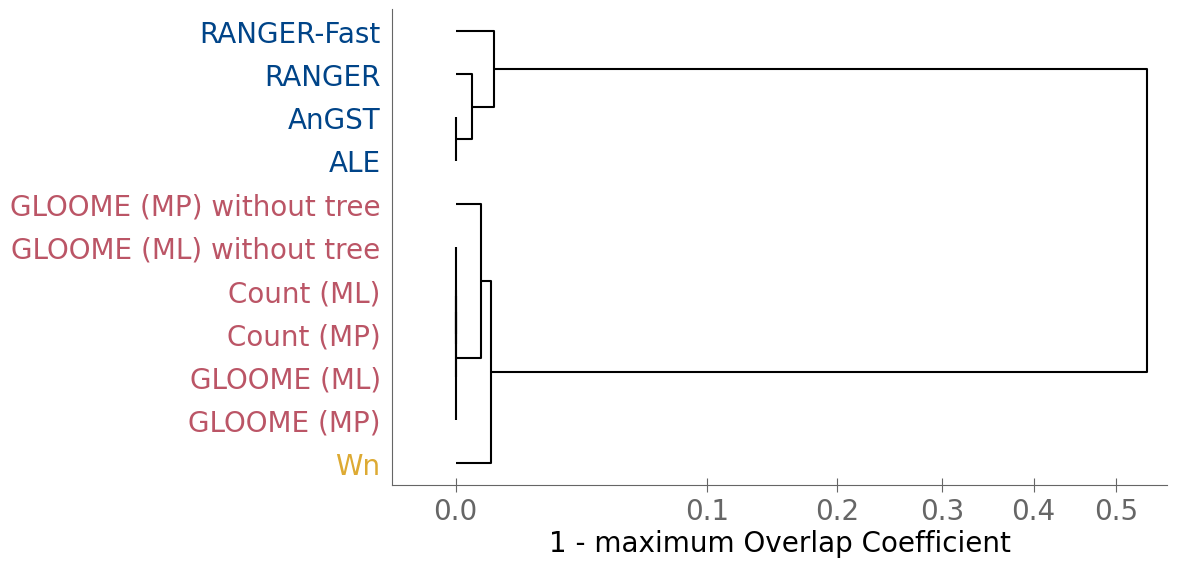

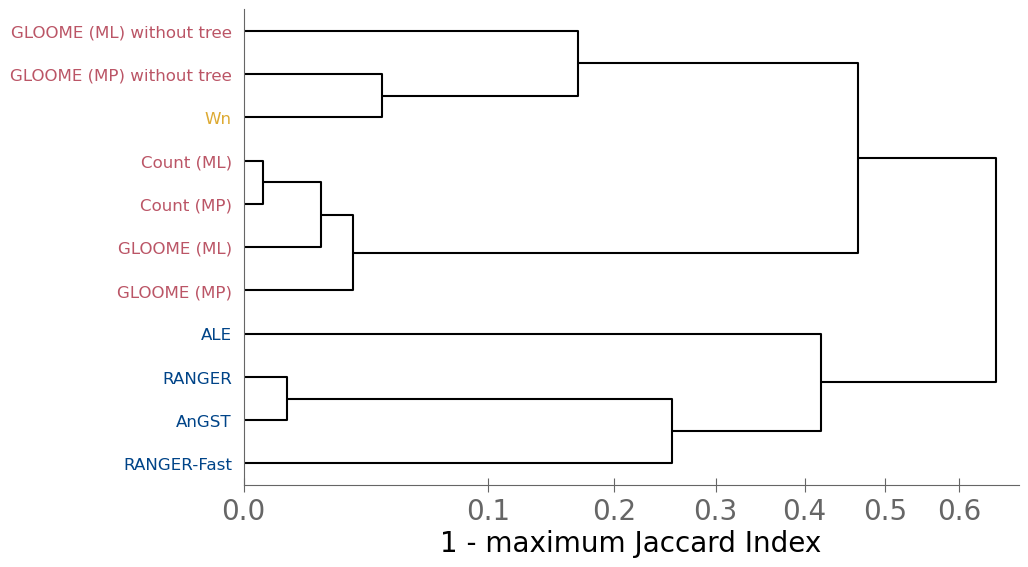

In [12]:

# rename the methods using the marker_styles_dict
method_label_dict = {method: marker_styles_dict[method]['label'] for method in methods_list}
method_label_dict_reverse = {v: k for k, v in method_label_dict.items()}
# summary_overlap_df['method1'] = summary_overlap_df['method1'].map(method_label_dict)
# summary_overlap_df['method2'] = summary_overlap_df['method2'].map(method_label_dict)

# display(summary_overlap_df)

# get the linkage matrix for overlap coefficient
max_overlap_pivot_df = summary_overlap_df.pivot(
    index='method1', columns='method2', values='1 - max_overlap_coefficient')
max_overlap_pivot_df = max_overlap_pivot_df.combine_first(
    max_overlap_pivot_df.T)
np.fill_diagonal(max_overlap_pivot_df.values, 0)
# relabel the methods using the marker_styles_dict
max_overlap_pivot_df.index = max_overlap_pivot_df.index.map(method_label_dict)
Z_overlap = linkage(squareform(max_overlap_pivot_df),
                    method=linkage_method, optimal_ordering=optimal_ordering)
# get the linkage matrix for jaccard index
max_jaccard_pivot_df = summary_overlap_df.pivot(
    index='method1', columns='method2', values='1 - max_jaccard_index')
max_jaccard_pivot_df = max_jaccard_pivot_df.combine_first(
    max_jaccard_pivot_df.T)
np.fill_diagonal(max_jaccard_pivot_df.values, 0)
# relabel the methods using the marker_styles_dict
max_jaccard_pivot_df.index = max_jaccard_pivot_df.index.map(method_label_dict)
Z_jaccard = linkage(squareform(max_jaccard_pivot_df),
                    method=linkage_method, optimal_ordering=optimal_ordering)

# plot the dendrogram
print(f'Dendrograms generated using linkage method:{
      linkage_method} and distances 1 - max overlap coefficient and 1 - max jaccard index. Note that the x-axis is transformed using a power transformation to make the distances more visible.')

fig1 = plt.figure()
# replace zeros in Z_overlap with min_distance
Z_overlap[Z_overlap == 0.0] = min_distance
d = dendrogram(Z_overlap, orientation='right', labels=max_overlap_pivot_df.index,
           color_threshold=color_threshold,
           above_threshold_color='black')
plt.xlabel('1 - maximum Overlap Coefficient')
ax = plt.gca(); axlbs = ax.get_ymajorticklabels()
for label in axlbs:
    # label.set_color(color_methods(label.get_text()))
    this_label_color = color_methods(method_label_dict_reverse[label.get_text()])
    label.set_color(this_label_color) # type: ignore

# increase xlabel size
plt.yticks(fontsize=20)
ax.set_xscale('function', functions=(power_transformation, power_transformation))
ax.set_xlim(-0.01, ax.get_xlim()[1])
plt.show()

fig2 = plt.figure()
dendrogram(Z_jaccard, orientation='right', labels=max_jaccard_pivot_df.index,
           color_threshold=color_threshold,
           above_threshold_color='black')
plt.xlabel('1 - maximum Jaccard Index')
plt.xscale('function', functions=(power_transformation, power_transformation))
ax = plt.gca(); axlbs = ax.get_ymajorticklabels()
for label in axlbs:
    # label.set_color(color_methods(label.get_text()))
    this_label_color = color_methods(method_label_dict_reverse[label.get_text()])
    label.set_color(this_label_color) # type: ignore
plt.show()

# save figures as png
fig1.savefig(os.path.join(plots_dir, 'dendrogram_max_overlap_coefficient.png'))
fig2.savefig(os.path.join(plots_dir, 'dendrogram_max_jaccard_index.png'))